# Сегментация изображений

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>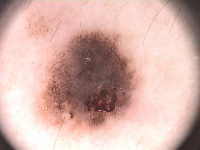</td><td>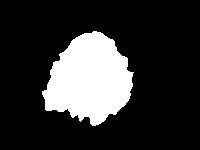</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [1]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

/bin/sh: wget: command not found


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

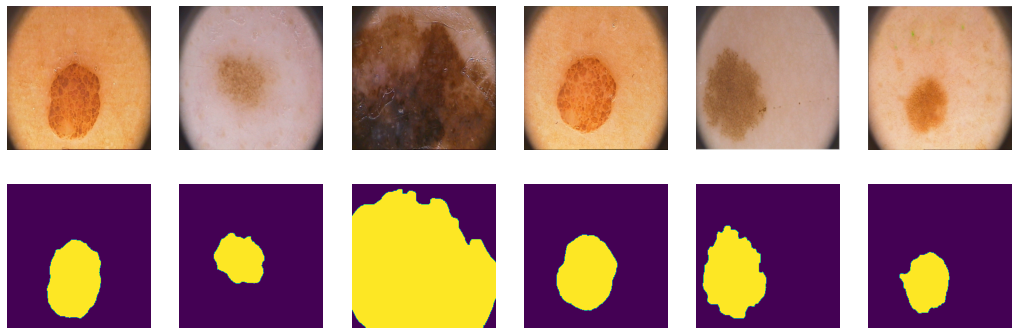

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


-----------------------------------------------------------------------------------------

# SegNet

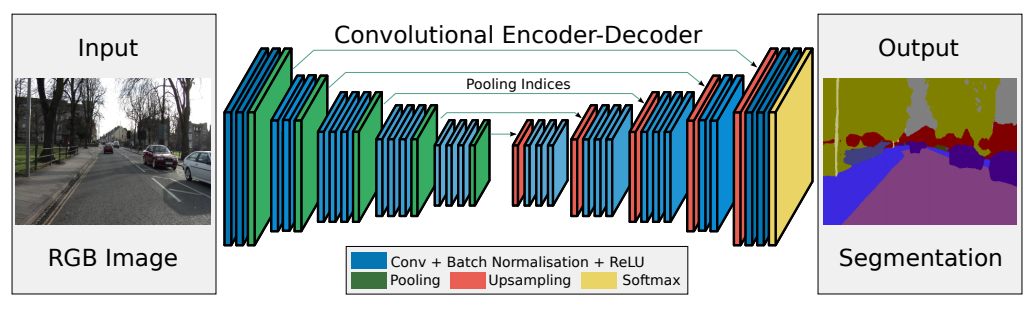

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [13]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3,
                                                 out_channels=64,
                                                 kernel_size=3,
                                                 padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU()
        )
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, 
                                  stride=2, 
                                  return_indices=True)

        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64,
                                                 out_channels=128,
                                                 kernel_size=3,
                                                 padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU()
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, 
                                  stride=2, 
                                  return_indices=True)

        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128,
                                                 out_channels=256,
                                                 kernel_size=3,
                                                 padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU()
        )
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, 
                                  stride=2, 
                                  return_indices=True)

        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256,
                                                 out_channels=512,
                                                 kernel_size=3,
                                                 padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU()
        )
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, 
                                  stride=2, 
                                  return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=512,
                                                       out_channels=512,
                                                       kernel_size=1,
                                                       padding=0),
                                             nn.BatchNorm2d(512),
                                             nn.Conv2d(in_channels=512,
                                                       out_channels=512,
                                                       kernel_size=1,
                                                       padding=0),
                                             nn.BatchNorm2d(512),
                                             nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2,
                                       stride=2)

        self.dec_conv0 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU()
        )
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, 
                                       stride=2) # 32 -> 64

        self.dec_conv1 = nn.Sequential(nn.ConvTranspose2d(in_channels=256,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU()
        )
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, 
                                       stride=2)  # 64 -> 128

        self.dec_conv2 = nn.Sequential(nn.ConvTranspose2d(in_channels=128,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU()
        )
        
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, 
                                       stride=2)  # 128 -> 256

        self.dec_conv3 = nn.Sequential(nn.ConvTranspose2d(in_channels=64,
                                                          out_channels=1,
                                                          kernel_size=3,
                                                          padding=1),
                                       nn.BatchNorm2d(1),
                                       nn.ReLU()
        )

    def forward(self, x):
        # encoder

        e0, ids0 = self.pool0(self.enc_conv0(x))
        e1, ids1 = self.pool1(self.enc_conv1(e0))
        e2, ids2 = self.pool2(self.enc_conv2(e1))
        e3, ids3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ids3))
        d1 = self.dec_conv1(self.upsample1(d0, ids2))
        d2 = self.dec_conv2(self.upsample2(d1, ids1))
        d3 = self.dec_conv3(self.upsample3(d2, ids0))
        return d3

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

-----------------------------------------------------------------------------------------

## BCE Loss

In [15]:
def bce_loss(y_real, y_pred):
  loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
  return loss.mean()

-----------------------------------------------------------------------------------------

## Тренировка

In [34]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, loss_history):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        loss_history.append(avg_loss)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().to('cpu') # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [35]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [36]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        scores += metric(Y_pred > 0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

Проводим тестирование:

In [37]:
model = SegNet().to(device)

In [38]:
torch.cuda.empty_cache()

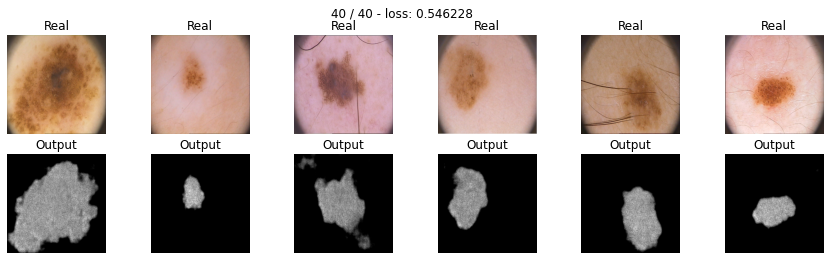

In [41]:
loss_history_bce = []

max_epochs = 40
opt = optim.Adam(model.parameters(), lr=3e-4)
train(model, opt, bce_loss, max_epochs, data_tr, data_val, loss_history_bce)

In [22]:
score_model(model, iou_pytorch, data_val)

0.7500000298023224

In [23]:
score_model(model, iou_pytorch, data_ts)

0.7179999649524689

-----------------------------------------------------------------------------------------

## Dice Loss

In [24]:
def dice_loss(y_real, y_pred, smooth=1e-6):
    y_pred = y_pred.sigmoid()

    num = (y_pred * y_real).sum(dim=(1, 2, 3))
    den = (y_pred + y_real).sum(dim=(1, 2, 3))
    res = 1 - 2 * num / (den + smooth)
    loss = res.mean()
    return loss

Проводим тестирование:

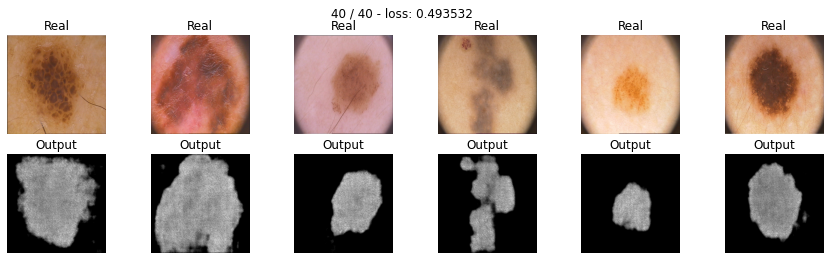

In [45]:
model_dice = SegNet().to(device)

loss_history_dice = []

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, loss_history_dice)

In [26]:
score_model(model_dice, iou_pytorch, data_val)

0.707999974489212

----------------------------------------------------------------------------------------------

## Focal Loss

In [27]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):

    bce = bce_loss(y_real, y_pred)
    pt = torch.exp(-bce)
    loss = (1 - pt)**gamma * bce
    return loss


Проводим тестирование:

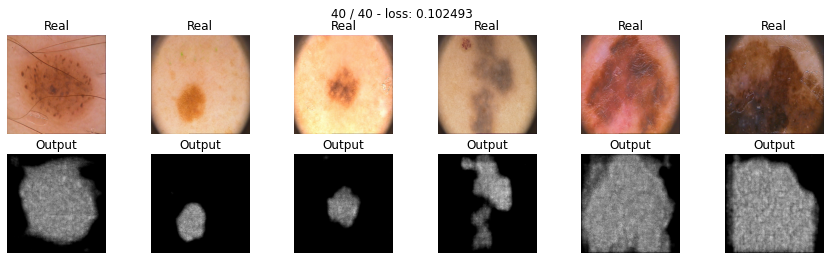

In [48]:
model_focal = SegNet().to(device)

loss_history_focal = []

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, loss_history_focal)

In [56]:
score_model(model_focal, iou_pytorch, data_val)

0.6620000004768372

----------------------------------------------------------------------------------------------

## Tverskiy Loss

In [30]:
def focal_tverskiy_loss(y_real, y_pred, smooth=1, alpha=0.5, gamma=2):
  y_pred = y_pred.sigmoid()

  TP = (y_pred * y_real).sum(dim=(1, 2, 3))
  FP = ((1 - y_real) * y_pred).sum(dim=(1, 2, 3))
  FN = (y_real * (1 - y_pred)).sum(dim=(1, 2, 3))
  res = 1 - (TP + smooth) / (TP + alpha * FP + (1 - alpha) * FN + smooth)
  loss = res.mean()                            
  loss = loss ** gamma

  return loss

Проводим тестирование:

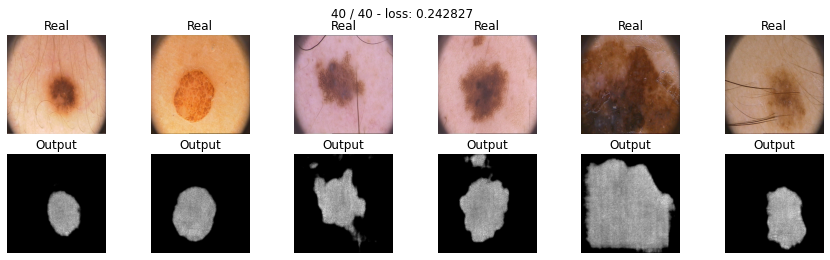

In [58]:
model_focal_tverskiy = SegNet().to(device)

loss_history_focal_tverskiy = []

max_epochs = 40
optimaizer = optim.Adam(model_focal_tverskiy.parameters())
train(model_focal_tverskiy, optimaizer, focal_tverskiy_loss, max_epochs, data_tr, data_val, loss_history_focal_tverskiy)

In [59]:
score_model(model_focal_tverskiy, iou_pytorch, data_val)

0.7620000243186951